In [1]:
import pandas as pd
import numpy as np
from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
import joblib
import zipfile
import os
import holidays
import wandb

warnings.filterwarnings('ignore')

# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 600) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded,

df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)
df= nan_fillers(df)
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['sea_level_pressure'].fillna(df['sea_level_pressure'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)
df=df.sort_values(by='timestamp')
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df['is_weekday']=df['dayofweek'] <= 5

In [2]:
df = df[["timestamp","site_id","building_id", "log_meter_reading"]]
df = df.groupby(['site_id', 'timestamp'])['log_meter_reading'].mean().reset_index()


In [3]:
data1 = df[df['site_id'] == 1]
data6 = df[df['site_id'] == 6]
data1 = data1.sort_values(by='timestamp')
data6 = data6.sort_values(by='timestamp')

In [28]:
window_size = 28  # You can adjust the window size
figsize = (24,6)

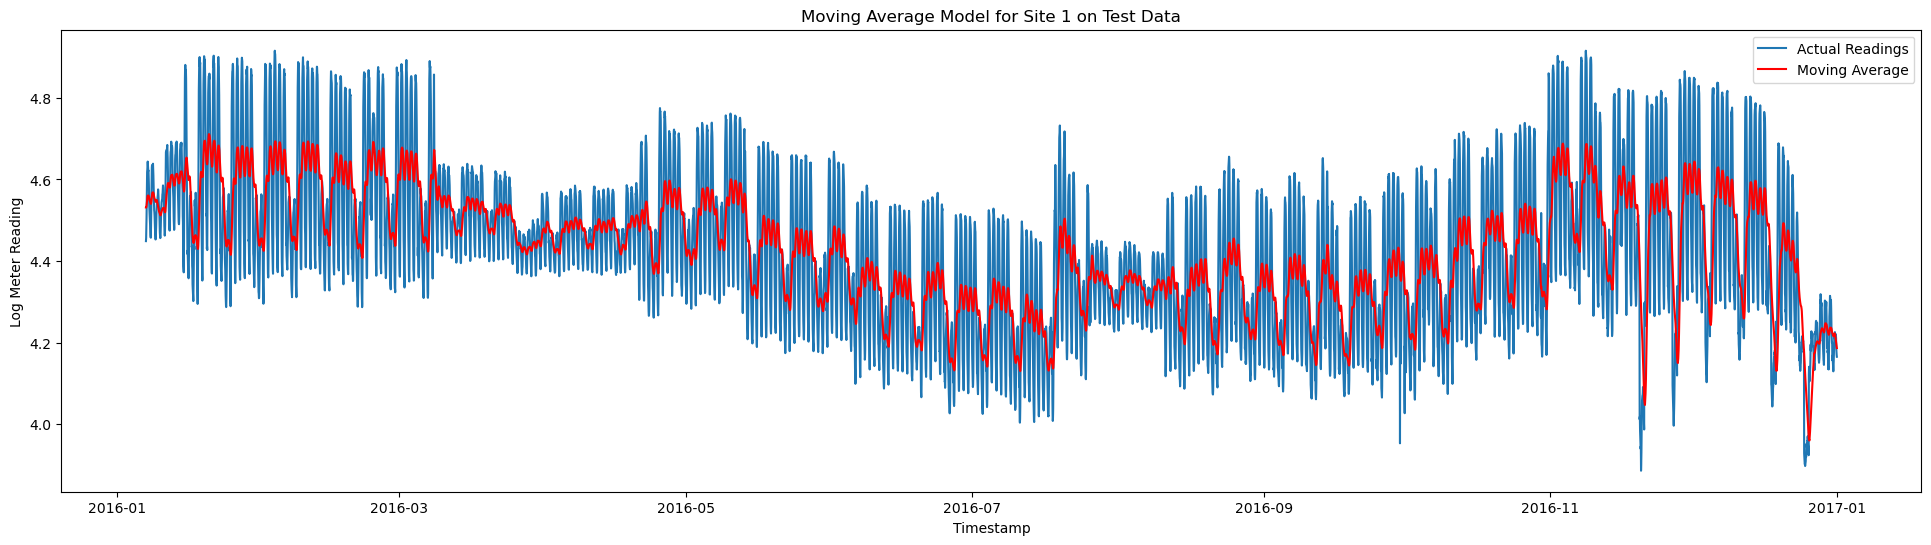

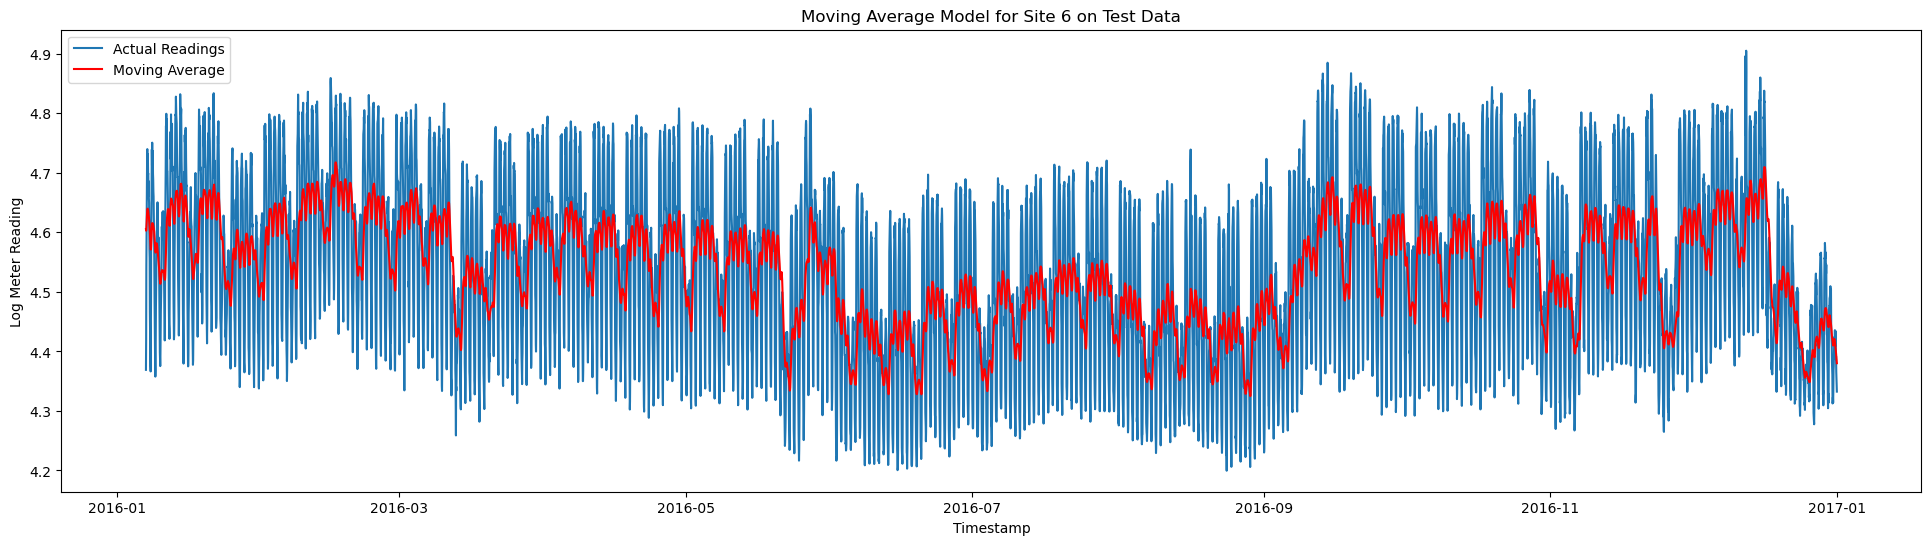

In [29]:
data1['rolling_mean'] = data1['log_meter_reading'].rolling(window=window_size).mean()
data1 = data1.dropna()

plt.figure(figsize=figsize)
plt.plot(data1['timestamp'], data1['log_meter_reading'], label='Actual Readings')
plt.plot(data1['timestamp'], data1['rolling_mean'], label='Moving Average', color='red')
plt.title('Moving Average Model for Site 1 on Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.legend()
plt.show()

data6['rolling_mean'] = data6['log_meter_reading'].rolling(window=window_size).mean()
data6 = data6.dropna()

plt.figure(figsize=figsize)
plt.plot(data6['timestamp'], data6['log_meter_reading'], label='Actual Readings')
plt.plot(data6['timestamp'], data6['rolling_mean'], label='Moving Average', color='red')
plt.title('Moving Average Model for Site 6 on Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.legend()
plt.show()




In [24]:
mse1 = mean_squared_error(data1['log_meter_reading'], data1['rolling_mean'])
mae1 = mean_absolute_error(data1['log_meter_reading'], data1['rolling_mean'])
mape1 = np.mean(np.abs((data1['log_meter_reading'] - data1['rolling_mean']) / 
                      (data1['log_meter_reading'] + 1e-10))) * 100
r21 = r2_score(data1['log_meter_reading'], data1['rolling_mean'])

mse6 = mean_squared_error(data6['log_meter_reading'], data6['rolling_mean'])
mae6 = mean_absolute_error(data6['log_meter_reading'], data6['rolling_mean'])
mape6 = np.mean(np.abs((data6['log_meter_reading'] - data6['rolling_mean']) / 
                      (data6['log_meter_reading'] + 1e-10))) * 100
r26 = r2_score(data6['log_meter_reading'], data6['rolling_mean'])

print("Mean Squared Error (MSE) for Site 1:", round(mse1,4))
print("Mean Absolute Error (MAE) for Site 1:", round(mae1,4))
print("Mean Absolute Percentage Error (MAPE) for Site 1:", round(mape1,4))
print("R-squared (R2) Score for Site 1:", round(r21,4))

print("----------")

print("Mean Squared Error (MSE) for Site 6:", round(mse6,4))
print("Mean Absolute Error (MAE) for Site 6:", round(mae6,4))
print("Mean Absolute Percentage Error (MAPE) for Site 6:", round(mape6,4))
print("R-squared (R2) Score for Site 6:", round(r26,4))

Mean Squared Error (MSE) for Site 1: 0.0015
Mean Absolute Error (MAE) for Site 1: 0.0293
Mean Absolute Percentage Error (MAPE) for Site 1: 0.6601
R-squared (R2) Score for Site 1: 0.9608
----------
Mean Squared Error (MSE) for Site 6: 0.0016
Mean Absolute Error (MAE) for Site 6: 0.0306
Mean Absolute Percentage Error (MAPE) for Site 6: 0.6763
R-squared (R2) Score for Site 6: 0.9341


# WandB Site-1

In [26]:
# Define a range of window sizes to test
window_sizes = range(1, 300 , 1) 

# Initialize WandB project
wandb.init(project='Moving-Average-Site1', entity="foresquad", notes='Moving Average Model Analysis')  # Replace 'your_entity_name' with your WandB username

for window_size in window_sizes:
    # Apply the moving average model to the test data
    rolling_mean = data1['log_meter_reading'].rolling(window=window_size).mean().dropna()

    # Calculate the performance metrics
    mse = mean_squared_error(data1['log_meter_reading'].loc[rolling_mean.index], rolling_mean)
    mae = mean_absolute_error(data1['log_meter_reading'].loc[rolling_mean.index], rolling_mean)
    mape = np.mean(np.abs((data1['log_meter_reading'].loc[rolling_mean.index] - rolling_mean) / 
                           (data1['log_meter_reading'].loc[rolling_mean.index] + 1e-10))) * 100
    r2 = r2_score(data1['log_meter_reading'].loc[rolling_mean.index], rolling_mean)

    # Log metrics to WandB
    wandb.log({'window_size_hour': window_size, 'mse': mse, 'mae': mae, 'mape': mape, 'r2': r2, 'arkulu-metric': r2/mape})


# Finish the WandB run
wandb.finish()

arkulu-metric,█▃▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,▁▅█▆▆▇▇▇▇█▇████████████▇▇▇▇▇▇▇▇█████████
mape,▁▅█▆▆▇▇▇▇█▇████████████▇▇▇▇▇▇▇██████████
mse,▁▄█▆▅▇▇▆▇█▇▇█▇██████▇█▇▇▇▇▇▇▇▇▇▇▇▇██████
r2,█▅▁▃▄▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁
window_size_hour,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
arkulu-metric,0.08404
mae,0.13946
mape,3.1442
mse,0.02853
r2,0.26425


# WandB Site-6 

In [27]:
# Define a range of window sizes to test
window_sizes = range(1, 300 , 1) 

# Initialize WandB project
wandb.init(project='Moving-Average-Site6', entity="foresquad", notes='Moving Average Model Analysis')  # Replace 'your_entity_name' with your WandB username

for window_size in window_sizes:
    # Apply the moving average model to the test data
    rolling_mean = data6['log_meter_reading'].rolling(window=window_size).mean().dropna()

    # Calculate the performance metrics
    mse = mean_squared_error(data6['log_meter_reading'].loc[rolling_mean.index], rolling_mean)
    mae = mean_absolute_error(data6['log_meter_reading'].loc[rolling_mean.index], rolling_mean)
    mape = np.mean(np.abs((data6['log_meter_reading'].loc[rolling_mean.index] - rolling_mean) / 
                           (data6['log_meter_reading'].loc[rolling_mean.index] + 1e-10))) * 100
    r2 = r2_score(data6['log_meter_reading'].loc[rolling_mean.index], rolling_mean)

    # Log metrics to WandB
    wandb.log({'window_size_hour': window_size, 'mse': mse, 'mae' : mae, 'mape': mape, 'r2': r2, 'arkulu-metric' : r2/mape})


# Finish the WandB run
wandb.finish()

arkulu-metric,█▃▁▂▂▁▂▂▂▁▂▂▁▂▁▁▁▂▁▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
mae,▁▅█▆▅▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
mape,▁▅█▆▅▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
mse,▁▄█▆▅▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
r2,█▅▁▃▄▂▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
window_size_hour,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
arkulu-metric,0.04779
mae,0.12307
mape,2.71872
mse,0.02081
r2,0.12994
